In [60]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [61]:
def add(a: int, b: int) -> int:
    ''' Add a and b
    Args:
        a: int
        b: int
    Return:
        int
    '''
    return a + b

In [62]:
add(23,20)

43

In [63]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [64]:
arxiv.invoke("LLM for cybersecurity")

'Published: 2024-12-04\nTitle: When LLMs Meet Cybersecurity: A Systematic Literature Review\nAuthors: Jie Zhang, Haoyu Bu, Hui Wen, Yongji Liu, Haiqiang Fei, Rongrong Xi, Lun Li, Yun Yang, Hongsong Zhu, Dan Meng\nSummary: The rapid development of large language models (LLMs) has opened new avenues\nacross various fields, including cybersecurity, which faces an evolving threat\nlandscape and demand for innovative technologies. Despite initial explorations\ninto the application of LLMs in cybersecurity, '

In [65]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [66]:
wiki.invoke("What is pen testing")

"Page: Penetration test\nSummary: A penetration test, colloquially known as a pentest, is an authorized simulated cyberattack on a computer system, performed to evaluate the security of the system; this is not to be confused with a vulnerability assessment. The test is performed to identify weaknesses (or vulnerabilities), including the potential for unauthorized parties to gain access to the system's features and data, as well as strengths, enabling a full risk assessment to be completed.\nThe pro"

In [67]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [68]:
tools=[wiki,arxiv,add]

In [69]:
from langchain_groq import ChatGroq
groq=ChatGroq(model="qwen-qwq-32b")
groq.invoke("What is testing")

AIMessage(content='\n<think>\nOkay, so the user is asking, "What is testing?" Let me start by breaking down what they might be looking for. They could be a beginner in a field like software development, quality assurance, or maybe even education. I should make sure to cover the basics without assuming too much prior knowledge.\n\nFirst, I need to define testing in general terms. Testing is the process of evaluating something to determine its quality, functionality, or reliability. But I should specify different contexts because testing can mean different things in different fields.\n\nIn software development, testing is crucial. Maybe I should explain that part first since it\'s a common area where testing is vital. I should mention types like unit testing, integration testing, system testing, and acceptance testing. Also, maybe touch on why it\'s important—like catching bugs early, ensuring requirements are met, and improving quality.\n\nThen there\'s educational testing, like exams a

In [70]:
llm_with_tools = groq.bind_tools(tools)
llm_with_tools.invoke("Reaserch on cybersecurity")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tgr5', 'function': {'arguments': '{"query":"Cybersecurity"}', 'name': 'wikipedia'}, 'type': 'function'}, {'id': 'call_ffzb', 'function': {'arguments': '{"query":"cybersecurity"}', 'name': 'arxiv'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 230, 'prompt_tokens': 389, 'total_tokens': 619, 'completion_time': 0.564875737, 'prompt_time': 0.02140985, 'queue_time': 0.250239184, 'total_time': 0.586285587}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_1e88ca32eb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f4f223da-945b-478b-a2c0-6ed110f7c2dd-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Cybersecurity'}, 'id': 'call_tgr5', 'type': 'tool_call'}, {'name': 'arxiv', 'args': {'query': 'cybersecurity'}, 'id': 'call_ffzb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 389, 'output_tokens': 230, 'total_tokens': 619})

In [71]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [72]:
def chatbot(state: State):
    return {"messages":llm_with_tools.invoke(state["messages"])}

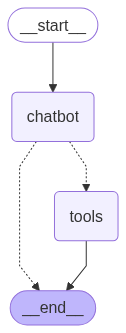

In [73]:
from IPython.display import Image
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.messages import HumanMessage

graph = StateGraph(State)
graph.add_node(
    "chatbot",
    chatbot
)
graph.add_node(
    "tools",
    ToolNode(tools)
)

graph.add_edge(START,"chatbot")
graph.add_conditional_edges("chatbot",tools_condition)
graph_builder = graph.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [74]:
messages=graph_builder.invoke({"messages":HumanMessage(content="What is your opinion on automaing cybersecurity")})

In [75]:
from pprint import pprint
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is your opinion on automaing cybersecurity
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_8m1e)
 Call ID: call_8m1e
  Args:
    query: Automated cybersecurity
  arxiv (call_vc9r)
 Call ID: call_vc9r
  Args:
    query: automating cybersecurity systems AI machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Pentera
Summary: Pentera is an American cybersecurity software company, specializing in automated security validation solutions. Originally founded as Pcysys in 2015, the company later rebranded as Pentera in 2021. The company is led by Amitai Ratzon (CEO) and Dr. Arik Liberzon (founder and CTO). Pentera has entities in the US, Germany, UK, Israel, Dubai, and Singapore.
================================= Tool Message =================================
Name: arxiv

Publish

## ReAct Agent Archicture
ReAct stands for Reasoning and Acting.
It allows LLMs to:

Reason through a problem step-by-step (like Chain-of-Thought).

Act by interacting with tools (e.g., a calculator, search engine, API) when needed.

Observe the result of those actions.

Continue reasoning or acting based on observations.


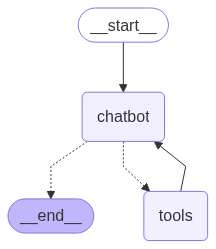

In [76]:
react = StateGraph(State)
react.add_node(
    "chatbot",
    chatbot
)

react.add_node(
    "tools",
    ToolNode(tools)
)

react.add_edge(START,"chatbot")
react.add_conditional_edges("chatbot",tools_condition)
react.add_edge("tools","chatbot")
react_builder = react.compile()
display(Image(react_builder.get_graph().draw_mermaid_png()))

In [79]:
react_messages=react_builder.invoke({"messages":HumanMessage(content="what is the values of the addition of 60 and 40")})
for message in react_messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is the values of the addition of 60 and 40
================================== Ai Message ==================================
Tool Calls:
  add (call_8whx)
 Call ID: call_8whx
  Args:
    a: 60
    b: 40
================================= Tool Message =================================
Name: add

100
================================== Ai Message ==================================

The result of adding 60 and 40 is **100**.
